# View Scenario Areas

This prints out a list of areas used in the scenarios together with the bounding boxes.

First, lets import everything we need:

In [1]:
import os
import glob
from statistics import mean

import geopandas as gpd
import plotly.graph_objects as go

from IPython.display import HTML
from shapely.geometry import Polygon, Point


## Scan folders

Then we define the folder structure and scan these for `.scn` files that contain the operator used to create aircrafts in `BlueSky`:

In [2]:
SEARCH_OPERATOR = ['POLY', 'CIRCLE']

scenario_files = os.path.join('..', '..', 'scenario', '**', '*.scn')
lines = []
for scenario_file in glob.glob(scenario_files, recursive=True):
    with open(scenario_file) as f:
        lines.extend([(scenario_file, line) for line in f.readlines() if any(map(line.__contains__, SEARCH_OPERATOR))])
print(f'Found {len(lines)} area definitions at "{scenario_files}"')

Found 7 area definitions at "..\..\scenario\**\*.scn"


## Extract areas

Each of these lines is then split according to the command definition to extract the names and types of areas used:

In [23]:
areas = []
for line in lines:
    scen = line[0]
    line = line[1].strip().split()
    type, name, coords = line[1].lower(), line[2], line[3:]
    if type == "poly":
        geo = Polygon([(float(p[1]), float(p[0])) for p in zip(coords[::2], coords[1::2])])
    elif type == "circle":
        lat, lon = float(coords[1]), float(coords[0])
        radius = float(coords[2]) * 1852
        point = gpd.GeoSeries(Point(lat, lon)).set_crs('EPSG:4326').to_crs('EPSG:3857')
        geo = point.buffer(radius).to_crs('EPSG:4326')[0]

    areas.append({
        "scenario": scen,
        "lon": mean([p[0] for p in geo.exterior.coords]),
        "lat": mean([p[1] for p in geo.exterior.coords]),
        "type": type,
        "name": name,
        "geometry": geo,
    })
gdf = gpd.GeoDataFrame(areas)

## Output

Finally, the `DataFrame` is plotted on a map...

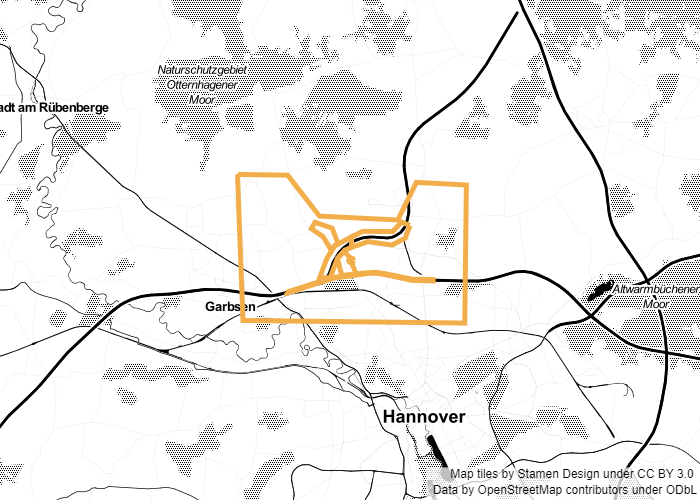

In [24]:
polys = []
for index, row in gdf.iterrows():
    poly = row.geometry
    plot = go.Scattermapbox(
        lon=list([p[0] for p in poly.exterior.coords]),
        lat=list([p[1] for p in poly.exterior.coords]),
        mode='lines',
        line_color='#f2ae4b',
        line_width=5
    )
    polys.append(plot)


fig = go.Figure(data=polys)
fig.update_mapboxes(
    style='stamen-toner',
    center_lon=gdf.lon.mean(),
    center_lat=gdf.lat.mean(),
    zoom=10,    
)
fig.update_layout(
    showlegend=False, 
    margin=dict(t=0, l=0, r=0, b=0),
    template="plotly_white"
)
fig.show("png")

...and converted to an `HTML` and [GeoJSON](data/areas.geojson) output:

In [28]:
with open('./data/areas.geojson', 'w') as f:
    g = gdf.to_json(show_bbox=True, indent=4, sort_keys=True)
    f.write(g)
HTML(gdf.to_html(escape=False))

,scenario,lon,lat,type,name,geometry
0,..\..\scenario\usepe_e3_ref.scn,9.676526,52.453022,poly,Traffic_area,"POLYGON ((9.60535 52.47166, 9.63983 52.47137, 9.66161 52.45426, 9.71544 52.45264, 9.72814 52.46835, 9.76250 52.46724, 9.76138 52.40947, 9.60913 52.41055, 9.60535 52.47166))"
1,..\..\scenario\USEPE\exercise_3\operation_areas.scn,9.706307,52.446543,poly,Op1,"POLYGON ((9.72381 52.45032, 9.71804 52.45172, 9.71182 52.44777, 9.69135 52.44786, 9.68339 52.44547, 9.68405 52.44127, 9.69491 52.44355, 9.71134 52.44214, 9.72055 52.44501, 9.72381 52.45032))"
2,..\..\scenario\USEPE\exercise_3\operation_areas.scn,9.674878,52.437748,poly,Op2,"POLYGON ((9.68405 52.44127, 9.68339 52.44547, 9.67205 52.44185, 9.66658 52.43643, 9.66173 52.42838, 9.66894 52.42852, 9.67402 52.43654, 9.67909 52.44000, 9.68405 52.44127))"
3,..\..\scenario\USEPE\exercise_3\operation_areas.scn,9.667196,52.445193,poly,Op3,"POLYGON ((9.67205 52.44185, 9.67441 52.44264, 9.67038 52.44915, 9.65860 52.45163, 9.65603 52.44902, 9.66413 52.44563, 9.66992 52.43977, 9.67205 52.44185))"
4,..\..\scenario\USEPE\exercise_3\operation_areas.scn,9.678410,52.434344,poly,Op4,"POLYGON ((9.67402 52.43654, 9.67849 52.43958, 9.68201 52.43724, 9.68675 52.43011, 9.67738 52.42935, 9.67620 52.43105, 9.67402 52.43654))"
5,..\..\scenario\USEPE\exercise_3\operation_areas.scn,9.683366,52.435720,circle,Op5,"POLYGON ((9.68500 52.43572, 9.68500 52.43562, 9.68497 52.43552, 9.68493 52.43543, 9.68488 52.43533, 9.68481 52.43524, 9.68472 52.43516, 9.68463 52.43508, 9.68452 52.43500, 9.68440 52.43494, 9.68426 52.43488, 9.68412 52.43483, 9.68398 52.43478, 9.68382 52.43475, 9.68366 52.43473, 9.68350 52.43471, 9.68334 52.43471, 9.68318 52.43471, 9.68302 52.43473, 9.68286 52.43475, 9.68270 52.43478, 9.68256 52.43483, 9.68242 52.43488, 9.68228 52.43494, 9.68216 52.43500, 9.68205 52.43508, 9.68196 52.43516, 9.68187 52.43524, 9.68180 52.43533, 9.68175 52.43543, 9.68171 52.43552, 9.68168 52.43562, 9.68168 52.43572, 9.68168 52.43582, 9.68171 52.43592, 9.68175 52.43601, 9.68180 52.43611, 9.68187 52.43620, 9.68196 52.43628, 9.68205 52.43636, 9.68216 52.43644, 9.68228 52.43650, 9.68242 52.43656, 9.68256 52.43661, 9.68270 52.43666, 9.68286 52.43669, 9.68302 52.43671, 9.68318 52.43673, 9.68334 52.43673, 9.68350 52.43673, 9.68366 52.43671, 9.68382 52.43669, 9.68398 52.43666, 9.68412 52.43661, 9.68426 52.43656, 9.68440 52.43650, 9.68452 52.43644, 9.68463 52.43636, 9.68472 52.43628, 9.68481 52.43620, 9.68488 52.43611, 9.68493 52.43601, 9.68497 52.43592, 9.68500 52.43582, 9.68500 52.43572))"
6,..\..\scenario\USEPE\exercise_3\operation_areas.scn,9.691546,52.427881,poly,HS_corridor,"POLYGON ((9.63884 52.42238, 9.67122 52.42859, 9.69099 52.43037, 9.70017 52.43075, 9.70648 52.43020, 9.72527 52.42783, 9.73969 52.42768, 9.73973 52.42714, 9.72510 52.42734, 9.70617 52.42985, 9.70104 52.43029, 9.69586 52.43029, 9.69107 52.42996, 9.67564 52.42875, 9.67114 52.42827, 9.63903 52.42191, 9.63884 52.42238))"
